In [1]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt
from forward_config import device, Pk, t_end, L, parameters
from torch.optim.lr_scheduler import ExponentialLR
import pandas as pd
import seaborn as sns


In [2]:
import numpy as np
from forward_config import L, t_end, Pk, C_skv, S, betta

def finite_diffs(Nh, Nt, k, G, glad, Q, mu_h):

    A, B, C, F = np.zeros(Nh), np.zeros(Nh), np.zeros(Nh), np.zeros(Nh)
    alfa, beta = np.zeros(Nh), np.zeros(Nh)
    P, Ps, Pn = np.zeros((Nh,Nt)), np.zeros(Nh), np.zeros(Nh)
    grad = np.zeros(Nh)


    h = (L)/(Nh-1)
    x = np.linspace(0, L, Nh)


    tau = t_end / (Nt-1)
    t = np.linspace(0,t_end,Nt)

    epsilon = 1.e-5

    P[:,0] = Pk

    def mu_oil(grad):
        mu_o = 4.62e-3
        return (mu_h-mu_o) / (1 + np.exp(glad * (grad - G))) + mu_o

    for j in range(1,Nt):
        Pn = P[:,j-1].copy()
        y = 0
        while True:
            if y==0:
                Ps = P[:,j-1].copy()
            else:
                Ps = P[:,j].copy()
            y += 1

            for i in range(1,Nh-1):
                grad[i] = (Ps[i+1]-Ps[i-1])/(2*h)
            grad[0] = (Ps[1]-Ps[0])/(h)
            grad[-1] = (Ps[-1]-Ps[-2])/(h)


            alfa[0] = (S*k/(mu_oil(grad[0])*h))/(C_skv/tau + S*k/(mu_oil(grad[0])*h))
            beta[0] = (-Q + C_skv/tau*Pn[0])/ (C_skv/tau + S*k/(mu_oil(grad[0])*h))


            for i in range(1, Nh-1):
                A[i] = 1. / h**2 * k / mu_oil(grad[i])
                B[i] = 1. / h**2 * k / mu_oil(grad[i])
                C[i] = A[i] + B[i] + betta/tau
                F[i] = betta/tau*Pn[i]

            for i in range(1, Nh-1):
                alfa[i]=A[i]/(C[i]-B[i]*alfa[i-1])
                beta[i]=(B[i]*beta[i-1]+F[i])/(C[i]-B[i]*alfa[i-1])

            P[-1][j] = Pk

            for i in range(Nh-2, -1, -1):
                P[i][j]=alfa[i]*P[i+1][j]+beta[i]

            u = abs((P[1][j]-Ps[1])/P[1][j])
            for i in range(Nh):
                if u < abs((P[i][j]-Ps[i])/P[i][j]):
                    u = abs((P[i][j]-Ps[i])/P[i][j])

            if u < epsilon:
                break

    return P, x, t

def mu_oil(grad):
    mu_o = 4.62e-3
    mu = (mu_h-mu_o) * torch.special.expit (-Pk/L*glad * (abs(grad) - L*G/Pk)) + mu_o

    return mu

class DNN(torch.nn.Module):
    def __init__(self, model):
        super(DNN, self).__init__()
        self.net = model
        self.loss_function = torch.nn.MSELoss(reduction ='mean')
        self.i = 0

    # Forward Feed
    def forward(self, x):
        return self.net(x)


    # Loss function for PDE
    def loss_pde(self, x):
        x.requires_grad = True
        y = self.net(x)
        p = y[:, 0:1].sum(0)

        dp_g, = torch.autograd.grad(p, x, create_graph=True)
        p_x, p_t = dp_g[:, :1], dp_g[:, 1:]

        p1 = p_x/mu_oil(p_x)

        d2p_g, = torch.autograd.grad(p1.sum(0), x, create_graph=True)

        p_xx, _ = d2p_g[:, :1], d2p_g[:, 1:]

        # Loss function for the Euler Equations
        f = p_t - t_end*k/(betta*L**2)*p_xx

        return torch.mean(f**2)

    # Loss function for initial condition
    def loss_dirichlet(self, x_bc, p_bc):
        p_bc_nn = self.net(x_bc)[:, 0]

        # Loss function for the initial condition
        loss_bcs = ((p_bc_nn - p_bc) ** 2)

        return loss_bcs

    def loss_operator(self, x_bc):
        x_bc.requires_grad=True
        y = self.net(x_bc)
        p = y[:, 0:1].sum(0)
        dp_g, = torch.autograd.grad(p, x_bc, create_graph=True)
        p_x, p_t = dp_g[:, 0], dp_g[:, 1]
        loss_bc = (p_x - mu_oil(p_x)*Q*L/(S*Pk*k) - C_skv*L/(t_end*S*k)*p_t*mu_oil(p_x))**2

        return loss_bc

In [3]:
params_rmse = []

for i ,key in enumerate(parameters):

    k = parameters[key]['k']
    G = parameters[key]['G']
    glad = parameters[key]['glad']
    Q = parameters[key]['Q']
    mu_h = parameters[key]['mu_h']

    device = torch.device(device)

    lr = 0.001
    epochs = 35000

    u = torch.linspace(0, 1, 50)
    t = torch.linspace(0, 1, 50)
    ###
    grid = torch.cartesian_prod(u,t).float().to(device)

    # p(u,0)=1
    bnd1 = torch.cartesian_prod(u, torch.tensor([0.])).float().to(device)
    bndval1 = torch.tensor([1.]).to(device)

    #bnd2(u(-1), t)=1
    bnd2 = torch.cartesian_prod(torch.tensor([1.]), t).float().to(device)
    bndval2 = torch.tensor([1.]).to(device)

    #bnd3
    bnd3 = torch.cartesian_prod(torch.tensor([0.]), t).float().to(device)

    NN = torch.nn.Sequential(
            torch.nn.Linear(2, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 1))


    # Initialize neural network
    model = DNN(NN).to(device)


    # Loss and optimizer
    optimizer = torch.optim.Adam(model.net.parameters(), lr)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

        # Train PINNs
    for epoch in range(epochs):
        model.train()

        def closure():
            optimizer.zero_grad()
            loss_pde = model.loss_pde(grid)
            loss_bnd1 = model.loss_dirichlet(bnd1, bndval1).reshape(-1)
            loss_bnd2 = model.loss_dirichlet(bnd2, bndval2).reshape(-1)
            loss_bnd3 = model.loss_operator(bnd3).reshape(-1)

            loss = 10*loss_pde + 1000*loss_bnd1.mean() + 100*(torch.hstack([loss_bnd2, loss_bnd3])).mean()

            loss.backward()
            return loss


        # Optimize loss function
        loss_pde = optimizer.step(closure)


        if epoch%3000 == 0:
            scheduler.step()

    pinn_sol = model(grid).detach().cpu().numpy().reshape(-1)

    fd_sol, xx, tt = finite_diffs(50, 50, k, G, glad, Q, mu_h)

    fd_sol = (fd_sol / Pk).reshape(-1)

    rmse = np.sqrt(np.sum((fd_sol - pinn_sol)**2)) / np.sqrt(np.sum(fd_sol**2))
    print("relative RMSE= ", rmse)
    params_rmse.append(rmse)

params_rmse
names = ['k', 'k', 'k', 'k',
         'G', 'G', 'G', 'G',
         'B', 'B', 'B', 'B',
         'q', 'q', 'q', 'q',
         '$\mu_H$', '$\mu_H$', '$\mu_H$', '$\mu_H$']

data = pd.DataFrame(params_rmse, columns=['value'])
data = pd.concat((data, pd.DataFrame(names, columns=['name'])), axis=1)
data.to_csv('errors_param.csv')

relative RMSE=  0.001351515964417814
relative RMSE=  0.0022904743305044166


C:\Users\user\AppData\Local\Temp\ipykernel_19488\2479687771.py:25: RuntimeWarning: overflow encountered in exp
  return (mu_h-mu_o) / (1 + np.exp(glad * (grad - G))) + mu_o


relative RMSE=  0.0007508074235429545
relative RMSE=  0.002368978410388176
relative RMSE=  0.0006334287734471964
relative RMSE=  0.00047900722995124456
relative RMSE=  0.0013368086952468268
relative RMSE=  0.012923299127749045
relative RMSE=  0.0015896422571198075
relative RMSE=  0.001191602318269727
relative RMSE=  0.0008876063171507987
relative RMSE=  0.004073455658366837
relative RMSE=  0.0008591806945113583
relative RMSE=  0.001375494571038195
relative RMSE=  0.002517405657665202
relative RMSE=  0.0025555776154553033
relative RMSE=  0.001866902010157734
relative RMSE=  0.010200251890346778
relative RMSE=  0.3234571865187225
relative RMSE=  0.010248227215445983


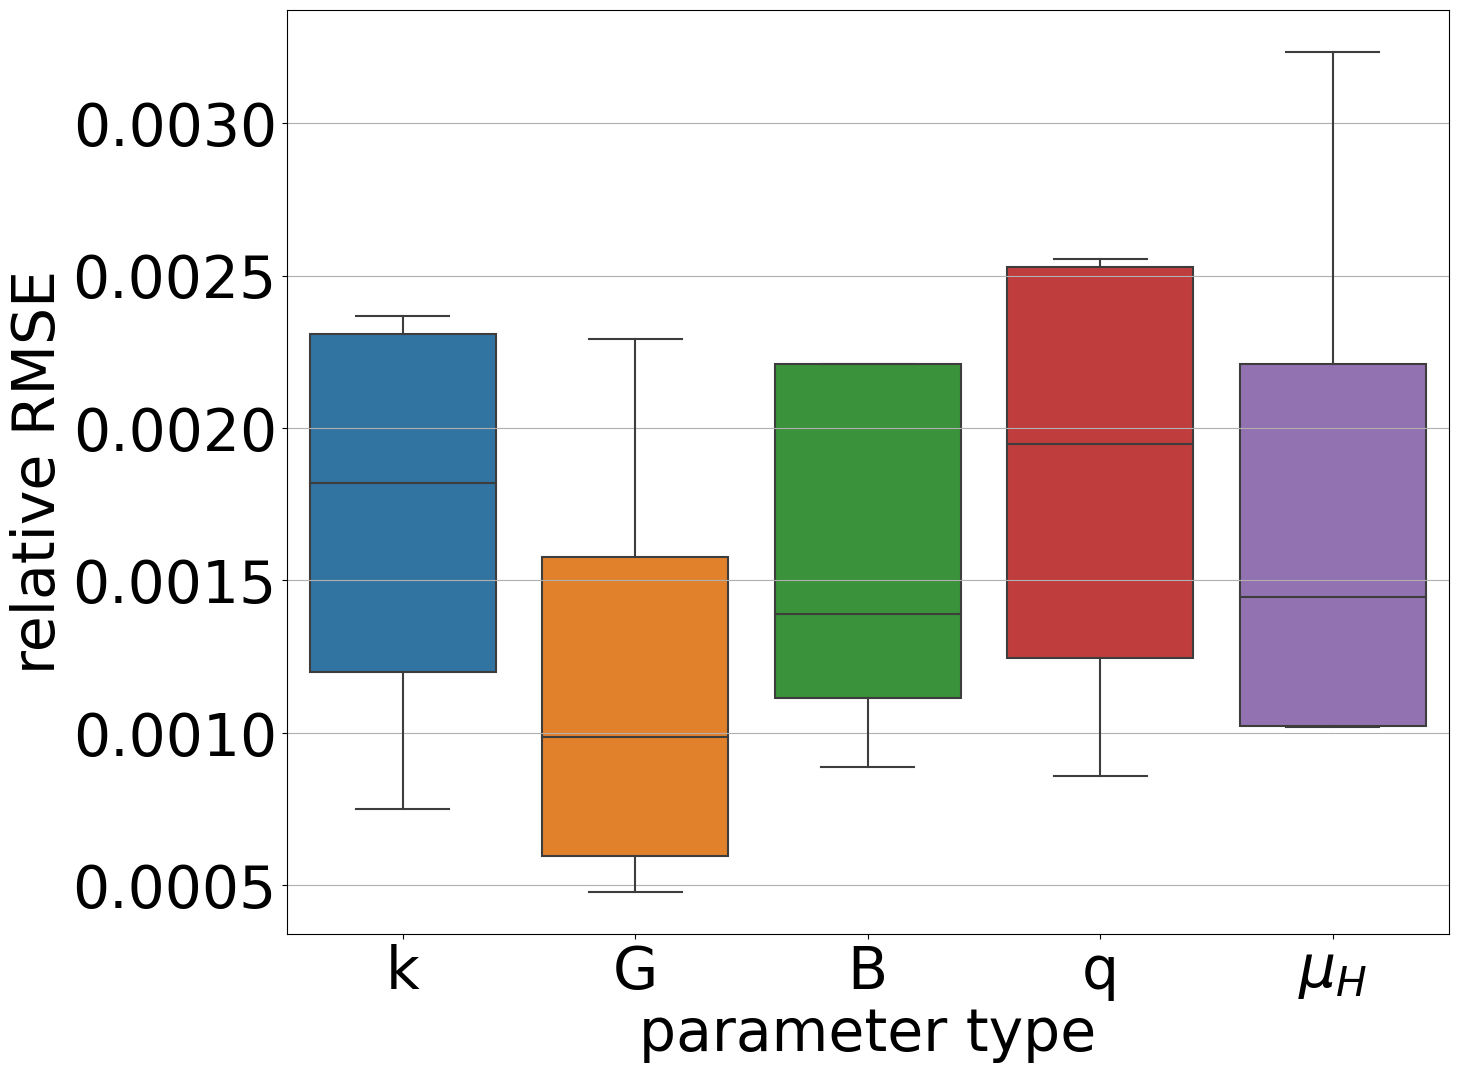

In [12]:
data = pd.read_csv('errors_param.csv')

plt.figure(figsize=(15,12))
plt.rc('font', size=42)
plt.grid()
sns.boxplot(x='name',y='value', data=data, showfliers=False)
plt.ylabel('relative RMSE')
plt.xlabel('parameter type')
plt.savefig('PINN_param_error.eps',dpi=1000, bbox_inches='tight')
